In [2]:
from __future__ import print_function
import librosa
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as pl
%matplotlib inline
import tensorflow as tf

pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip


In [3]:
content  = 'inputs/imperial.mp3'
style = 'inputs/usa.mp3'

In [4]:
display(Audio(content))
display(Audio(style))

y: audio time series

sr: sampling rate

In [11]:
# Read wav file and produce spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))
    return S,fs

In [14]:
a_content, _ = read_audio_spectrum(content)
a_style, _ = read_audio_spectrum(style)

N_samples = a_content.shape[1]
N_channels = a_content.shape[0]
a_style = a_style[:N_channels, :N_samples]

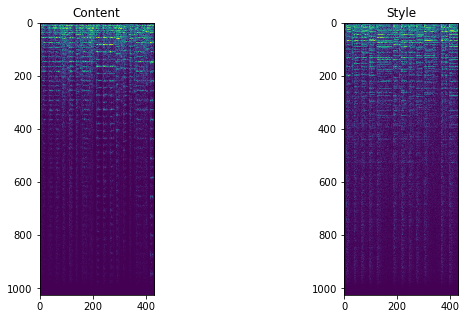

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content)
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style)
plt.show()

In [24]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_channels + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_channels, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_samples,N_channels], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_samples

In [25]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_samples,N_samples).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

ValueError: Dimensions must be equal, but are 430 and 1025 for 'conv' (op: 'Conv2D') with input shapes: [1,1,430,430], [1,11,1025,4096].